### Описание задачи и процесса

По условию задания страницы документов могут быть отсканированы в различном порядке. Человек с легкостью определит, какой документ и на каком пункте открыт. Для методов машинного обучения нарушенный порядок может стать серьезной проблемой, как с класификацией, так и с распознаванием сущностей на документе.  

С проблемой классификации мы разобрались с помощью алгоритма ручного набора токенов и обучения алгоритма на собранных данных. Данный метод позволил нам выявлять представленный документ с точностью до 99% процентов. Алгоритму практически неважно, какая страница документа входит в него первой.  

Для более глубоко анализа и последующего сохранения ценных данных мы создали базовый пайп на основе сверточной нейронной сети и библиотеки OpenCV.  

Данных на руках немного, мы покажем работу алгоритма на примерах Свидетельств АГР. 
Для своевременной сдачи проекта в этом ноутбуке мы демонстрируем скелет пайплайна без привязки к бекэнду.

### Алгоритм

Пайплайн выглядит так:

1. Отсканированный документ проходит первичную классификацию;  
2. Система переводит распознанный тип документа из pdf в jpeg;  
3. Документ последовательно обрабатывается нейросейтью, каждая страница получает свой лейбл. Номер страницы является ключом для отправки страницы в нужную функцию распознавания текста по предобученной маске;  
4. Алгоритм выделяет заданные атрибуты, конвертирует  их в изображения и отправляет на распознание текста;  
5. Распознанные блоки информации получают маркировку, связываются с первичным документом и отправляются в базу данных. Оператор может обращаться к документу сразу после завершения работы алгоритма.  

Для полного набора данных на втором этапе для распознания сущностей мы будем использовать RCNN. В текущем варианте на небольшом датасете для теста пайпа применяем OpenCV.

In [136]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import keras

Первый шаг - перевод pdf в jpeg. Подружаем заранее подготовленные данные. Мы перевели все имеющиеся на руках документы АРГ, смешали последовательность. Для финального теста выбрали одну случайную карту, которую не пускали в обучение нейросети.

In [141]:
check_front = cv2.imread('../input/train-pics/37_Page_1.jpg')
check_back = cv2.imread('../input/train-pics/37_Page_3.jpg')

Все предварительные этапы реальной модели буду проводиться на отдельных вычислительных мощностях. Результатом работы станет модель, которая уже имплементируется в бэк.

In [129]:
train_data_dir = '../input/pics-class/data/train'
validation_data_dir = '../input/pics-class/data/valid'

img_width, img_height = 150, 200
nb_train_samples = 126
nb_validation_samples = 22

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Архитектура содержит три сверточных слоя. Это количество избыточно для исследуемых документов, но будет полезно с другими типами документов.

In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Операции создания обучающей и валидационной выборки останутся без изменений в финальном проекте. Вырастет только объем данных. Для датагена применяем небольшой зум и поворот изображений, имитируя различные варианты сканирования.

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)


test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 126 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


На малых данных применяем 10 эпох и небольшой размер батча.

In [25]:
epochs = 10
batch_size = 2

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
63/63 [==============================] - 6s 92ms/step - loss: 0.8919 - accuracy: 0.4603 - val_loss: 0.6495 - val_accuracy: 0.5909
Epoch 2/10
63/63 [==============================] - 6s 95ms/step - loss: 0.4884 - accuracy: 0.8095 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 3/10
63/63 [==============================] - 6s 101ms/step - loss: 0.0207 - accuracy: 1.0000 - val_loss: 1.7988e-06 - val_accuracy: 1.0000
Epoch 4/10
63/63 [==============================] - 6s 96ms/step - loss: 0.0956 - accuracy: 0.9683 - val_loss: 8.6300e-05 - val_accuracy: 1.0000
Epoch 5/10
63/63 [==============================] - 6s 99ms/step - loss: 0.2324 - accuracy: 0.9206 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 6/10
63/63 [==============================] - 6s 99ms/step - loss: 0.0605 - accuracy: 0.9841 - val_loss: 9.2036e-12 - val_accuracy: 1.0000
Epoch 7/10
63/63 [==============================] - 6s 89ms/step - loss: 4.3977e-04 - accuracy: 1.0000 - val_loss: 3.0147e-12 - val_accuracy:

Имеющиеся документы качественно отсканированны. Практически не имеют шумов и поворотов. Процесс обучения занимает примерно 1 минуту и показывает единички в обучающей и валидационной выборках.

Для второго этапа пропишем графики качества обучения. В демонстрационном примере они не несут большого смысла.

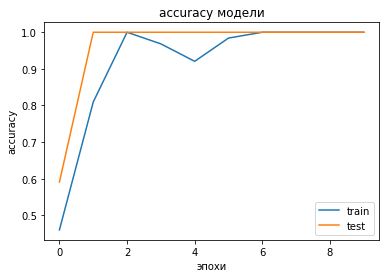

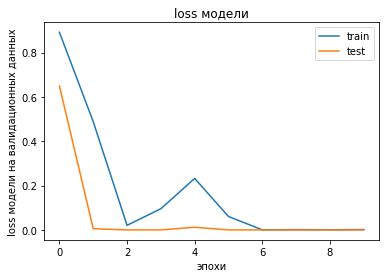

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy модели')
plt.ylabel('accuracy')
plt.xlabel('эпохи')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss модели')
plt.ylabel('loss модели на валидационных данных')
plt.xlabel('эпохи')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Проверим качество работы модели на валидационных данных.

In [139]:
test_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(150, 200),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

y_pred = np.rint(predict)
y_true = test_generator.classes

print()
print('roc_auc модели', roc_auc_score(y_true, y_pred))
print()
print(classification_report(y_true, y_pred))

Found 22 images belonging to 2 classes.

roc_auc модели 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



На небольшом количестве одинаковых данных - идеальные метрики.

Страницам присваиваются лейблы:

0 - обратная сторона;  
1 - лицевая сторона. 

В документах иного типа можно создать классификацию по документам: первая / не первая. Или если документ имеет четко заданное количество страниц, увеличить количество лейблов.

In [51]:
#model.save('/kaggle/working/page_classification_001.h5')
#model_2 = keras.models.load_model("./page_classification_001.h5")

Архитектура модели и количество параметров.

In [54]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 198, 32)      896       
_________________________________________________________________
activation_20 (Activation)   (None, 148, 198, 32)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 99, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 97, 32)        9248      
_________________________________________________________________
activation_21 (Activation)   (None, 72, 97, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 48, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 46, 64)       

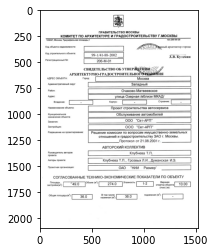

In [147]:
img_front = check_front
img_size = cv2.resize(img_front,(150,200))
img_shaped = np.reshape(img_size,[1,150,200,3])

classes = model_2.predict_classes(img_shaped)
plt.imshow(img_front);

Мы скормили модели первую страницу, лейб должен быть 1

In [148]:
classes[0]

array([1], dtype=int32)

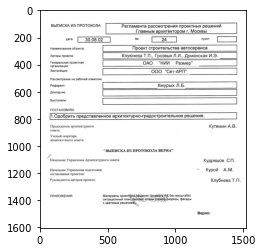

In [150]:
img_back = check_back
img_size = cv2.resize(img_back,(150,200))
img_shaped = np.reshape(img_size,[1,150,200,3])

classes = model_2.predict_classes(img_shaped)
plt.imshow(img_back);

In [151]:
classes[0]

array([0], dtype=int32)

На выборочном примере алгоритм сработал.  
Далее изображение подается на парсинг.

In [175]:
### Словарь сущностей
BONES_FRONT = {0:'общая площадь', 1:'наземная площадь', 2:"поднемная площадь", 
         3:"верхняя отметка", 4:'площадь застройки', 5:'объем', 6:"этажность",
         7:"проектная организация", 8:"авторы проекта", 9:"руководитель авторов",
         10:"разрешение на проектирование", 11:"застройшик", 12:"заказчик", 
         13:"функциональное назначение", 14:"наименование объекта", 15:"владение",
         16:"корпус", 17:"строение", 18:"адрес", 19:"район", 20:"округ", 21:"город",
         24:"регистрационный номер", 25:"код строительного объекта", 26:"код недвижимости", 27:"дата"}
 
 ### Парс первой страницы ###    
 
def parse_front(img_front):
 ### cv предобработка    
    gray = cv2.cvtColor(img_front,cv2.COLOR_BGR2GRAY)
    thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    blur = cv2.GaussianBlur(thresh_inv,(1,1),0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
 ### находим контуры
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
 ### переменные для присвоения номеров
    UPD = [54,  55,  60, 122, 129, 135, 136, 233, 250, 289, 450, 464, 475,
           508, 529, 558, 559, 560, 567, 576, 599, 620, 734, 771, 842]
    KEYS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26]
 

    crop_list = []
    for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if w*h >3000:
                crop = img_front[y:h+y,x:w+x]
                crop_list.append(crop)
                
    for  key_, num in zip(UPD, KEYS):
        x, y, w, h = cv2.boundingRect(contours[key_])
 
 
### Путь сохранения можно менять
        plt.imsave('{}'.format(num)+'.png', img_front[y:h+y,x:w+x])
 
 
 ### Парс второй страницы ###   
 
def parse_back(img_back):
 
    gray = cv2.cvtColor(train_02,cv2.COLOR_BGR2GRAY)
    thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    blur = cv2.GaussianBlur(thresh_inv,(1,1),0)
 
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
 
    x, y, w, h = cv2.boundingRect(contours[715])
 
 ### Путь сохранения можно менять
    plt.imsave('{}'.format(27)+'.png', train_02[y:h+y,x:w+x])

Применяем обе функции в выбранным сканам

In [174]:
parse_front(check_front)

In [176]:
parse_back(check_back)

На выходе мы получаем изображения под номерами, которые соответствуют ключам словяра с названиями сущностей.

![](https://i.ibb.co/3T3f6s3/image.png)

Посмотрим на получившиеся изображения

![](https://i.ibb.co/rZJFnq6/000.png)

BONES_FRONT[0] == 'общая площадь'

![](https://i.ibb.co/Pg3nqHS/025.png)

BONES_FRONT[25] == 'код строительного объекта'

![](https://i.ibb.co/Y2YDRhs/027.png)

BONES_FRONT[27] == 'дата составления', со второй страницы

Далее выделенные объекты отправляются на OCR и в базу данных.

### Заключение 

Данный алгоритм содержит в себе легко масштабируемый код и отличается высокой скоростью работы. 
Сеть и маска выделения сущностей обладают большим количеством настраиваемых параметров для адаптации к новым документам.

Алгоритм хорошо показыват вдумчивый и фундаментальный подход нашей команды к серьезным задачам. На втором этапе с большим набором данных мы планируем применять алгоритмы глубокого обучениия для достижения максимального качества работы.